# Fine-Tuning Pipeline

In [1]:
import pandas as pd
import numpy as np
import random
import time
import datetime
import torch
## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
## PyTorch Transformer
from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig
from torchnlp.encoders import LabelEncoder
from torch.utils.data import TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-PCIE-16GB


In [3]:
#@title

def clean_text(text):
    import re
    #from nltk.corpus import stopwords

    REPLACE_BY_SPACE_RE = re.compile('[.#+_/(){}\[\]\|@,;-]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
    #STOPWORDS = set(stopwords.words('english'))
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    
    """
    try:
        return text.replace(re.findall(r'(\d{5,10})', text)[0],'') # remove pincodes mentioned in address if exists
    except:
        return text
    
    """
    return text

In [4]:
def run_clean_address(df,col_name): #given raw address column, clean address and output term frequency dataframe
    
    import re

    addresses = df[col_name].map(lambda x: ' '.join(re.split('(\d+)',x)))
    #addresses = addresses.map(lambda x: re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", x).strip())
    
    addresses = addresses.apply(clean_text)
    #addresses = addresses.map(lambda x : re.sub(r'\b\w{1,5}\b', '', x) ) #hyperparameter : removing tokens which are not very long

    df["address_tokens"] = addresses.str.split()
    df["address_clean"] = df["address_tokens"].map(lambda x: ' '.join(x))
    
    return df

In [5]:
pwd

'/data/home/deploy/shreyas/fine-tuning_exp'

In [6]:
ls

BERT_Address_Classifier_Faridabad.ipynb
model_combinedBertBLGRWHF/
model_combinedBertFAR/
model_DelhiNCR_PreTrained_BertFAR/
model_prepropcombinedBertFAR/
model_prepropcombinedBertWHF/
preprop_RoBERTa_Address_Classifier_Finetuning-BLR-WHF.ipynb
preprop_RoBERTa_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning-BGLR-WHF.ipynb
RoBERTa_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning-DELHI-NCR-NDA.ipynb
RoBERTa_Address_Classifier_Finetuning.ipynb
RoBERTa_Pre-Trained_On_Only_Delhi_NCR_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb


In [7]:
train_df = pd.read_csv('/home/deploy/shreyas/addressData/FAR/FAR_address_train_BERT.csv')
print("done")

# Report the number of sentences.
print('Number of train_df sentences: {:,}\n'.format(train_df.shape[0]))

done
Number of train_df sentences: 82,574



In [8]:
train_df.head()

id                                            address  \
0  402204908  Village gounchhi near bich wali maszid, Balbhgarh   
1  402204302  ,Fatehpur Billoch ,House no. 243/4,Ward no. 58...   
2  402203486  Flat no J77 jal Vidyut Apartment , Sector 21C ...   
3  402193986       House no. 5486 sector -3, Faridabad Sector 3   
4  402181038          House no 435, new Bhoor Colony, FARIDABAD   

                                       address_clean  \
0  village gounchhi near bich wali maszid balbhga...   
1  fatehpur billoch house no 243 4 ward no 58 teh...   
2  flat no j 77 jal vidyut apartment sector 21 c ...   
3   house no 5486 sector 3 faridabad sector 3 121004   
4     house no 435 new bhoor colony faridabad 121002   

                               address_clean_preprop route_id  
0  village gonchhi near bich wali maszid ballabhg...      r31  
1  fatehpur billoch house no 243 4 ward no 58 teh...      r39  
2  flat no j 77 jal vidyut apartment sector 21 c ...      r49  
3            house no 5486 sector 3 faridabad 121004      r31  
4     house no 435 new bhoor colony faridabad 121002      r20

In [9]:
train_df['address_clean'][12000]

'house number 668 second floor sector 31 faridabad haryana sector 31 121003'

In [10]:
train_df.head(5)

id                                            address  \
0  402204908  Village gounchhi near bich wali maszid, Balbhgarh   
1  402204302  ,Fatehpur Billoch ,House no. 243/4,Ward no. 58...   
2  402203486  Flat no J77 jal Vidyut Apartment , Sector 21C ...   
3  402193986       House no. 5486 sector -3, Faridabad Sector 3   
4  402181038          House no 435, new Bhoor Colony, FARIDABAD   

                                       address_clean  \
0  village gounchhi near bich wali maszid balbhga...   
1  fatehpur billoch house no 243 4 ward no 58 teh...   
2  flat no j 77 jal vidyut apartment sector 21 c ...   
3   house no 5486 sector 3 faridabad sector 3 121004   
4     house no 435 new bhoor colony faridabad 121002   

                               address_clean_preprop route_id  
0  village gonchhi near bich wali maszid ballabhg...      r31  
1  fatehpur billoch house no 243 4 ward no 58 teh...      r39  
2  flat no j 77 jal vidyut apartment sector 21 c ...      r49  
3            house no 5486 sector 3 faridabad 121004      r31  
4     house no 435 new bhoor colony faridabad 121002      r20

In [11]:
test_df = pd.read_csv('/home/deploy/shreyas/addressData/FAR/FAR_address_test_BERT.csv')
print("done")

# Report the number of sentences.
print('Number of test_df sentences: {:,}\n'.format(test_df.shape[0]))

done
Number of test_df sentences: 13,805



In [12]:
test_df.head()

id                                            address  \
0  416646652  573 sector 15a near telephone exchange, faridabad   
1  416636226  House no.-1185, Lane no.-6, near Atal chowk, S...   
2  416634642  Ip extension 2 4128 first floor front side, Se...   
3  416631820  Piyush heights Flat no D 413 sector 89  farida...   
4  416631012                         667 sector 21C , faridabad   

                                       address_clean  \
0  573 sector 15 a near telephone exchange farida...   
1  house no 1185 lane no 6 near atal chowk sanjay...   
2  ip extension 2 4128 first floor front side sec...   
3  piyush heights flat no d 413 sector 89 faridab...   
4                   667 sector 21 c faridabad 121001   

                               address_clean_preprop route_id  
0  573 sector 15 a near telephone exchange farida...      r15  
1  house no 1185 lane no 6 near atal chowk sanjay...      r40  
2  ip extension 2 4128 first floor front side sec...      r44  
3  piyush heights flat no d 413 sector 89 faridab...      r12  
4                   667 sector 21 c faridabad 121001      r49

# Fine-tuning using address cleaned in the same way as in pre-training without probabilistic cleaning steps

In [13]:
#dataset = train_df.append(test_df, ignore_index=True)

In [14]:
sentences = train_df.address_clean.values
labels = train_df.route_id.values

encoder = LabelEncoder(labels)
labels = encoder.batch_encode(train_df.route_id.values)

# Loading Pre-Trained Roberta Model And Preprocessing Input Data

In [15]:
tokenizer = RobertaTokenizer.from_pretrained('/home/deploy/shreyas/combinedData/BGLRNCRaddressBERT-small-v1')
config = RobertaConfig.from_pretrained("/home/deploy/shreyas/combinedData/BGLRNCRaddressBERT-small-v1")
print("done")

done


In [16]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


In [17]:
num_classes = len(encoder.vocab)
print("num_classes including 'unk' ", num_classes)

num_classes including 'unk'  87


In [18]:
config.num_labels = num_classes
model = RobertaForSequenceClassification(config)

In [19]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  village gounchhi near bich wali maszid balbhgarh 121004
Tokenized:  ['village', 'Ġgoun', 'chhi', 'Ġnear', 'Ġb', 'ich', 'Ġwali', 'Ġmaszid', 'Ġbal', 'bh', 'garh', 'Ġ121004']
Token IDs:  [3220, 29707, 15283, 331, 265, 5301, 1501, 10914, 845, 1529, 1062, 1608]


In [20]:
model.cuda(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [21]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  village gounchhi near bich wali maszid balbhgarh 121004
Token IDs: tensor([    0,   600, 29707, 15283,   331,   265,  5301,  1501, 10914,   845,
         1529,  1062,  1608,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


In [22]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

81,748 training samples
  826 validation samples


In [23]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [24]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 107 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (30000, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [25]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [26]:


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Roberta Fine-Tuning 

In [29]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of  2,555.    Elapsed: 0:00:03.
  Batch    80  of  2,555.    Elapsed: 0:00:06.
  Batch   120  of  2,555.    Elapsed: 0:00:09.
  Batch   160  of  2,555.    Elapsed: 0:00:13.
  Batch   200  of  2,555.    Elapsed: 0:00:16.
  Batch   240  of  2,555.    Elapsed: 0:00:19.
  Batch   280  of  2,555.    Elapsed: 0:00:22.
  Batch   320  of  2,555.    Elapsed: 0:00:25.
  Batch   360  of  2,555.    Elapsed: 0:00:28.
  Batch   400  of  2,555.    Elapsed: 0:00:31.
  Batch   440  of  2,555.    Elapsed: 0:00:34.
  Batch   480  of  2,555.    Elapsed: 0:00:37.
  Batch   520  of  2,555.    Elapsed: 0:00:41.
  Batch   560  of  2,555.    Elapsed: 0:00:44.
  Batch   600  of  2,555.    Elapsed: 0:00:47.
  Batch   640  of  2,555.    Elapsed: 0:00:50.
  Batch   680  of  2,555.    Elapsed: 0:00:53.
  Batch   720  of  2,555.    Elapsed: 0:00:56.
  Batch   760  of  2,555.    Elapsed: 0:00:59.
  Batch   800  of  2,555.    Elapsed: 0:01:02.
  Batch   840  of  2,555.    Elapsed: 0:01:05.
  Batch   880

  Batch 1,640  of  2,555.    Elapsed: 0:02:10.
  Batch 1,680  of  2,555.    Elapsed: 0:02:13.
  Batch 1,720  of  2,555.    Elapsed: 0:02:16.
  Batch 1,760  of  2,555.    Elapsed: 0:02:19.
  Batch 1,800  of  2,555.    Elapsed: 0:02:22.
  Batch 1,840  of  2,555.    Elapsed: 0:02:26.
  Batch 1,880  of  2,555.    Elapsed: 0:02:29.
  Batch 1,920  of  2,555.    Elapsed: 0:02:32.
  Batch 1,960  of  2,555.    Elapsed: 0:02:36.
  Batch 2,000  of  2,555.    Elapsed: 0:02:39.
  Batch 2,040  of  2,555.    Elapsed: 0:02:42.
  Batch 2,080  of  2,555.    Elapsed: 0:02:45.
  Batch 2,120  of  2,555.    Elapsed: 0:02:48.
  Batch 2,160  of  2,555.    Elapsed: 0:02:52.
  Batch 2,200  of  2,555.    Elapsed: 0:02:55.
  Batch 2,240  of  2,555.    Elapsed: 0:02:58.
  Batch 2,280  of  2,555.    Elapsed: 0:03:01.
  Batch 2,320  of  2,555.    Elapsed: 0:03:04.
  Batch 2,360  of  2,555.    Elapsed: 0:03:07.
  Batch 2,400  of  2,555.    Elapsed: 0:03:10.
  Batch 2,440  of  2,555.    Elapsed: 0:03:13.
  Batch 2,480

In [30]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.994698986644381,
  'Valid. Loss': 0.6137119468588096,
  'Valid. Accur.': 0.8471708579881656,
  'Training Time': '0:03:20',
  'Validation Time': '0:00:01'},
 {'epoch': 2,
  'Training Loss': 0.5031572779097436,
  'Valid. Loss': 0.48745625294171846,
  'Valid. Accur.': 0.884430473372781,
  'Training Time': '0:03:20',
  'Validation Time': '0:00:01'},
 {'epoch': 3,
  'Training Loss': 0.4185671347548817,
  'Valid. Loss': 0.47427529440476346,
  'Valid. Accur.': 0.8883136094674556,
  'Training Time': '0:03:22',
  'Validation Time': '0:00:01'},
 {'epoch': 4,
  'Training Loss': 0.3690338913504391,
  'Valid. Loss': 0.4497152314736293,
  'Valid. Accur.': 0.8919193786982249,
  'Training Time': '0:03:18',
  'Validation Time': '0:00:01'}]

In [31]:
pwd

'/data/home/deploy/shreyas/fine-tuning_exp'

# Model Saving

In [32]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_combinedBertFAR/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_combinedBertFAR/


('./model_combinedBertFAR/vocab.json',
 './model_combinedBertFAR/merges.txt',
 './model_combinedBertFAR/special_tokens_map.json',
 './model_combinedBertFAR/added_tokens.json')

In [33]:
ls

BERT_Address_Classifier_Faridabad.ipynb
model_combinedBertBLGRWHF/
model_combinedBertFAR/
model_DelhiNCR_PreTrained_BertFAR/
model_prepropcombinedBertFAR/
model_prepropcombinedBertWHF/
preprop_RoBERTa_Address_Classifier_Finetuning-BLR-WHF.ipynb
preprop_RoBERTa_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning-BGLR-WHF.ipynb
RoBERTa_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning-DELHI-NCR-NDA.ipynb
RoBERTa_Address_Classifier_Finetuning.ipynb
RoBERTa_Pre-Trained_On_Only_Delhi_NCR_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb


# Evaluation on Hidden Test Set

In [34]:
import pandas as pd

# Load the dataset into a pandas dataframe.

# Report the number of sentences.
print('Number of test addresses: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df.address_clean.values
labels = test_df.route_id.values

labels = encoder.batch_encode(test_df.route_id.values)



# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 64  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test addresses: 13,805



/home/deploy/.conda/envs/shreyasvenv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [94]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, pred_labels, confidence = [], [], [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  pred_labels_batch = [np.argmax(i) for i in logits]
  confidence_batch = [torch.nn.functional.softmax(torch.FloatTensor(np.array(i).reshape(1,-1))).numpy().max() for i in logits]


  
  # Store predictions and true labels
  predictions.append(logits)
  pred_labels.append(pred_labels_batch)
  true_labels.append(label_ids)
  confidence.append(confidence_batch)

print('    DONE.')

Predicting labels for 13,805 test sentences...


/home/deploy/.conda/envs/shreyasvenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


    DONE.


In [95]:
pred_labels_flat = [item for sublist in pred_labels for item in sublist]
true_labels_flat = [item for sublist in true_labels for item in sublist]
confidence_flat = [item for sublist in confidence for item in sublist]

In [96]:
accuracy_score(pred_labels_flat,true_labels_flat)

0.8417240130387541

In [97]:
test = pd.DataFrame({"id":test_df['id'].values,"address":test_df['address'],'address_clean':test_df['address_clean'],'address_clean_preprop':test_df['address_clean_preprop'],"route_id":encoder.batch_decode(torch.IntTensor(true_labels_flat)),"pred_route_id":encoder.batch_decode(torch.IntTensor(pred_labels_flat)),"confidence_score":confidence_flat})
print("done")


done


In [98]:
test.head()

id                                            address  \
0  416646652  573 sector 15a near telephone exchange, faridabad   
1  416636226  House no.-1185, Lane no.-6, near Atal chowk, S...   
2  416634642  Ip extension 2 4128 first floor front side, Se...   
3  416631820  Piyush heights Flat no D 413 sector 89  farida...   
4  416631012                         667 sector 21C , faridabad   

                                       address_clean  \
0  573 sector 15 a near telephone exchange farida...   
1  house no 1185 lane no 6 near atal chowk sanjay...   
2  ip extension 2 4128 first floor front side sec...   
3  piyush heights flat no d 413 sector 89 faridab...   
4                   667 sector 21 c faridabad 121001   

                               address_clean_preprop route_id pred_route_id  \
0  573 sector 15 a near telephone exchange farida...      r15           r21   
1  house no 1185 lane no 6 near atal chowk sanjay...      r40           r42   
2  ip extension 2 4128 first floor front side sec...      r44           r44   
3  piyush heights flat no d 413 sector 89 faridab...      r12           r12   
4                   667 sector 21 c faridabad 121001      r49           r49   

   confidence_score  
0          0.618763  
1          0.656110  
2          0.997586  
3          0.993240  
4          0.969675

In [99]:
test.loc[test["confidence_score"]<=test.confidence_score.quantile(0.1),"quantile"]=test.confidence_score.quantile(0.1)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.1))&(test["confidence_score"]<=test.confidence_score.quantile(0.2)),"quantile"]=test.confidence_score.quantile(0.2)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.2))&(test["confidence_score"]<=test.confidence_score.quantile(0.3)),"quantile"]=test.confidence_score.quantile(0.3)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.3))&(test["confidence_score"]<=test.confidence_score.quantile(0.4)),"quantile"]=test.confidence_score.quantile(0.4)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.4))&(test["confidence_score"]<=test.confidence_score.quantile(0.5)),"quantile"]=test.confidence_score.quantile(0.5)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.5))&(test["confidence_score"]<=test.confidence_score.quantile(0.6)),"quantile"]=test.confidence_score.quantile(0.6)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.6))&(test["confidence_score"]<=test.confidence_score.quantile(0.7)),"quantile"]=test.confidence_score.quantile(0.7)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.7))&(test["confidence_score"]<=test.confidence_score.quantile(0.8)),"quantile"]=test.confidence_score.quantile(0.8)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.8))&(test["confidence_score"]<=test.confidence_score.quantile(0.9)),"quantile"]=test.confidence_score.quantile(0.9)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.9)),"quantile"]=test.confidence_score.quantile(1.0)




In [100]:
q=test["quantile"].unique().tolist()
q.sort()
print(q)

acc_vs_confidence_plot = pd.DataFrame({"quantile":q,"accuracy":np.zeros(len(test["quantile"].unique())),"support":np.zeros(len(test["quantile"].unique()))})


[0.6765839338302613, 0.889549732208252, 0.9551235556602478, 0.9773352384567261, 0.9870907068252563, 0.9915741205215454, 0.9938907861709595, 0.9952755689620971, 0.9964768052101135, 0.9982962012290955]


In [101]:
for i in range(len(acc_vs_confidence_plot)):
    acc_vs_confidence_plot.at[i, 'accuracy'] = len(test.loc[(test["quantile"]==acc_vs_confidence_plot["quantile"].iloc[i])&(test["route_id"]==test["pred_route_id"])])/float(len(test.loc[test["quantile"]==acc_vs_confidence_plot["quantile"].iloc[i]]))
    acc_vs_confidence_plot.at[i,"support"] = len(test.loc[test["quantile"]==acc_vs_confidence_plot["quantile"].iloc[i]])


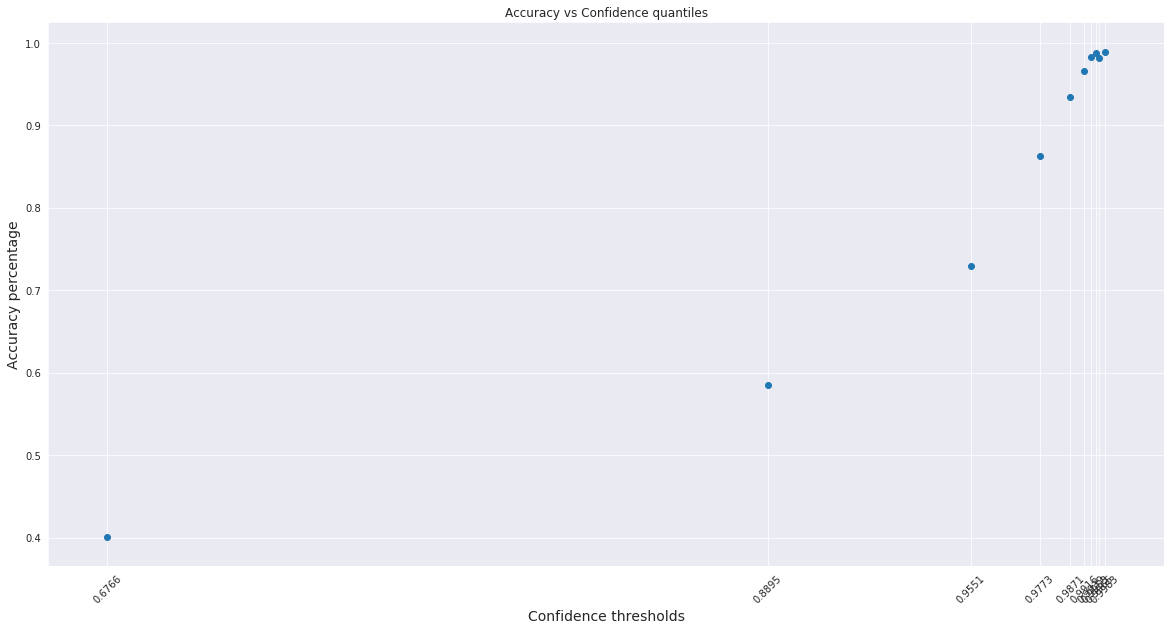

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
#sns.barplot(acc_vs_entropy_plot["quantile"],acc_vs_entropy_plot["accuracy"], alpha=1.0,palette="rocket")
sns.set_style("darkgrid")
plt.scatter(acc_vs_confidence_plot["quantile"],acc_vs_confidence_plot["accuracy"])
plt.xticks(list(acc_vs_confidence_plot["quantile"]),rotation=45)
plt.title('Accuracy vs Confidence quantiles')
plt.ylabel('Accuracy percentage', fontsize=14)
plt.xlabel('Confidence thresholds', fontsize=14)
plt.show()

In [107]:
list(test.loc[test['confidence_score']<0.67]['address'])

['573 sector 15a near telephone exchange, faridabad',
 'House no.-1185, Lane no.-6, near Atal chowk, Sanjay Enclave, NIT Faridabad, Sanjay Enclave',
 'House no  431, second floor',
 'H.no.6475 gf gate no 5 , sai nath chowk , faridabad',
 '99 Block 3 Sector 62 Aashiyana',
 'H.No 264, Prem Nagar, Yadav Colony',
 'House no-60/1, gurukul inder prasth, sarai khawaja, green field',
 'k-208 rama krishna apartment',
 'A wing, Flat No. 903, Hamilton Tower, Near Hanuman Chowk.',
 'AXIS BANK SCOF 55, HUDA MARKET',
 'C/o State Bank of India, 43/2 Mile stone',
 '56',
 '588',
 'House number 838, behind jan kalyaan mandir',
 'House no 701,sector 15 a faridabad haryana',
 'House no 1844',
 'House no 635, sector 21D, near housing board colony, faridabad haryana',
 'Flat no 605, Hillgrow ApptartmentsSector 21-c-iiiFaridabad',
 'H-no.677, Sector 15-A, Faridabad',
 '#2198, 1st floor, Huda staff colony',
 '811, Gali No.4, Near Chopra Tent House',
 'House No. 1268',
 'Jawan,faridabad near KMP SCHOOL',
 'Hou